<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/PDSH-cover-small.png?raw=1">

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

<!--NAVIGATION-->
< [In-Depth: Manifold Learning](05.10-Manifold-Learning.ipynb) | [Contents](Index.ipynb) | [In Depth: Gaussian Mixture Models](05.12-Gaussian-Mixtures.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.11-K-Means.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


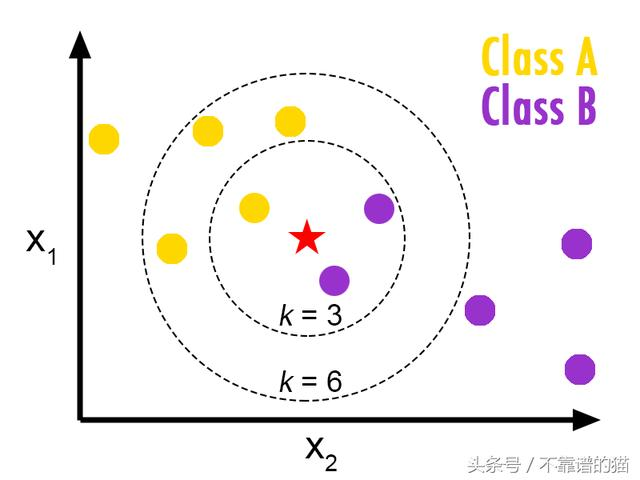

# In Depth: k-Means Clustering

前面的PCA是非監督式學習，還有另一種是KNN。

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

## k-Means介紹

KNN在一個未標籤的多維資料集中搜尋一個預先定義數目的群組。它藉由使用一個簡單的最佳化集群看起來的樣子之概念來完成:
- 群組中心是所有同一群組中的所有點之算數平均
- 群組中的每一個點都比其他群組的點還要更接近群組中心

這2個假設是*k*-means模型的基礎。


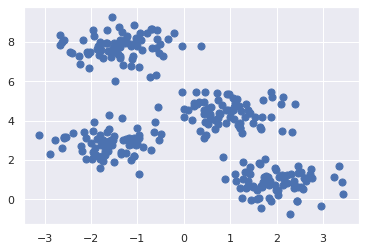

In [3]:
# 產生二維含有4個獨立的區塊，並視覺化
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

By eye, it is relatively easy to pick out the four clusters.
The *k*-means algorithm does this automatically, and in Scikit-Learn uses the typical estimator API:

In [4]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

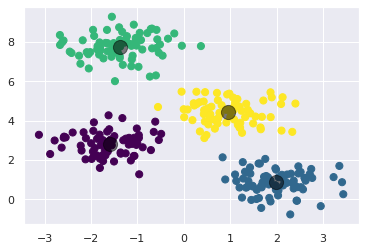

In [5]:
# 用顏色化出視覺化結果，也標出被KNN所決定的群組中心
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

KNN的結果和我們預期猜想的結果很類似，KNN包含了一個直覺得迭代嘗試，就是所謂的*最大期望算法(expectation-maximization)*

## KNN: 最大期望算法(Expectation–Maximization)

最大期望(E–M)是一個具有威力的演算法，應用在資料科學的許多不同領域中。k-means是一個特別簡單而且容易理解的演算法應用。

最大期望法是由以下幾個程序所組成:
1. 猜測一些群組的中心
2. 重複直到收斂:
   1. *E-Step*: 指定一些點到最近的群組中心
   2. *M-Step*: 設定群組中心為其平均值 

"E-step"或"Expectation step"包含了更新我們對於每一個點屬於群組之期望。
"M-step"或"Maximization step"因為包含最大化一些適應函數(fitness function)，這些函數定義了群組中心的位置。

在典型的環境中，每一次E-Step和M-step重複將總是會產生一個對於群組特性更好的評估。

![(run code in Appendix to generate image)](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.11-expectation-maximization.png?raw=1)
[figure source in Appendix](06.00-Figure-Code.ipynb#Expectation-Maximization)

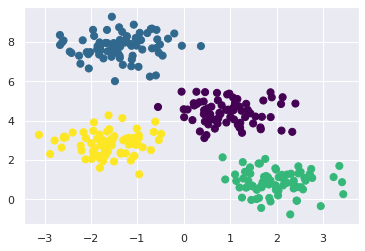

In [6]:
# 簡單操作KNN
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. 隨機選取群組
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. 基於最近的中心設定標籤
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. 從點的平均找出新的中心
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. 檢查是否收斂
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

### 最大期望算法的一些警示

有一些使用最大期望演算法的問題需要去注意。

#### 全體最佳化的結果可能無法達到
E–M程序保證在每一步改善其結果，但無法保證它可以達成*全體*的最佳化。

例如:如果我們使用一個不同的隨機種子在我們的簡單程序中，有一些特定的猜測將會導致很差的結果。

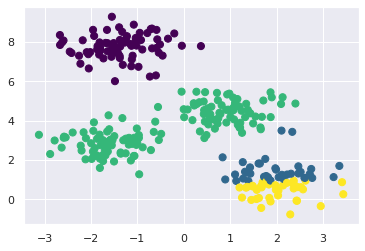

In [8]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

在此E–M嘗試已經收斂了，但並沒有收斂到最佳位置。因為這個理由，此演算法經常被使用多個不同的起始猜測執行多次，實際上Scikit-Learn在預設的情況下就會這麼做(以``n_init``參數來設定次數，預設值是10)。

#### 必須事先設定群組的數目
*k*-means的另一個常見的挑戰是你必須先設定預期的群組數目；它沒辦法從資料中學習到群組的數目。

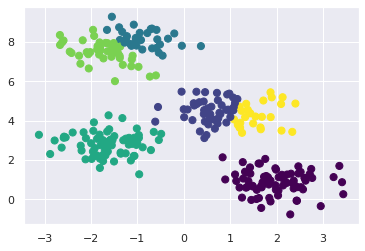

In [9]:
# 要求此演算法識別出6個群組，會很快找出最佳的6個群組
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

#### k-means被限制在線性群組邊界
*k*-means的基本模型假設(資料點為比在其他群組中的點更接近自己的群組中心)代表此演算法在遇到複雜幾何形狀的群組時經常是無效的。

尤其是，*k*-means的群組邊界都是線性的，代表如果遇到更複雜的邊界就會失敗。

In [10]:
# 考慮以下資料，透過典型的k-means找出來的群組標籤
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0) # Make two interleaving交錯 half circles.

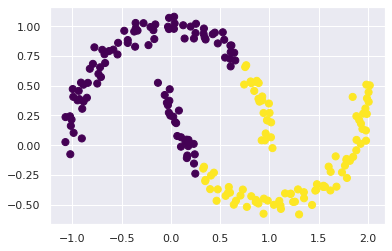

In [11]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

其中一個核化版本的*k*-means被實作在Scikit-Learn之``SpectralClustering``評估器。它使用最近鄰圖(graph of nearest neighbors)去計算一個資料之更高維度表示，然後使用*k*-means演算法指定標籤:

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


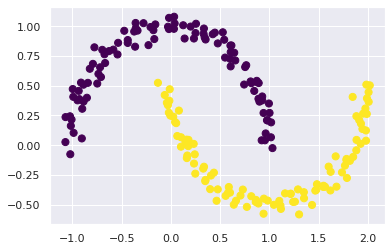

In [12]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

可以看到透過此核轉換的嘗試，核化*k*-means就能夠找出群組間更加複雜的非線性邊界了。

#### 大量樣本會讓k-means執行變慢

因為k-means每一次的迭代都必須存取資料集中的每一個點，此演算法相對來說就會在資料量龐大時變慢。

### 範例: 在數字元上使用k-means

嘗試使用*k*-means到試著在*沒有使用原始標籤資訊*的情況下去識別相似的數字元;這可能會和在從你沒有任何事前有關於標籤資訊的情況下，擷取出新資料集的意義之運算類似。 

從載入數字元開始，然後找出``KMeans``群組。回想之前的這些數字元有1,797個樣本以及64個特徵，其中64個特徵值就是在8×8影像中某一個像素的亮度:

In [13]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [14]:
# 集群可以被像之前一樣的執行如下:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

結果會是在64個維度中出現10個群組。留意這些群組的中心是64維度的資料點，而它們可以被解釋為在群組中典型的數字元。

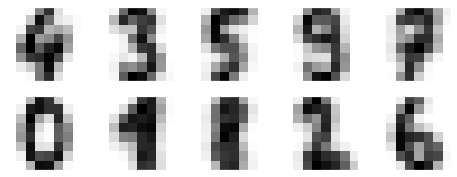

In [15]:
# 檢視此群組中心的樣子
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

可以看到*就算是沒有標籤*，``KMeans``也是能夠找出可以被辨識的群組中心，除了1和8之外。

因為*k*-means對於如何分別出群組沒有任何的了解，所以0–9的標籤可能會沒有正確的被排列。在此可以透過把每一個學習到的群組，和從它們之中找出的實際標籤做配對來修正此種情況:

In [16]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [17]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7935447968836951

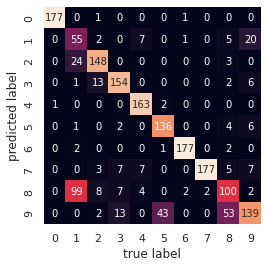

In [18]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');